<a href="https://colab.research.google.com/github/yhtang/SINN/blob/main/OU_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jun 19 18:56:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 PCIe               Off |   00000000:A8:00.0 Off |                    0 |
| N/A   34C    P0             77W /  350W |       0MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    PositionalEncoding,
    SINN_transformer,
    FPU
)

In [3]:
device = torch.device('cuda')

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

320.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(800, 400) (800, 400)


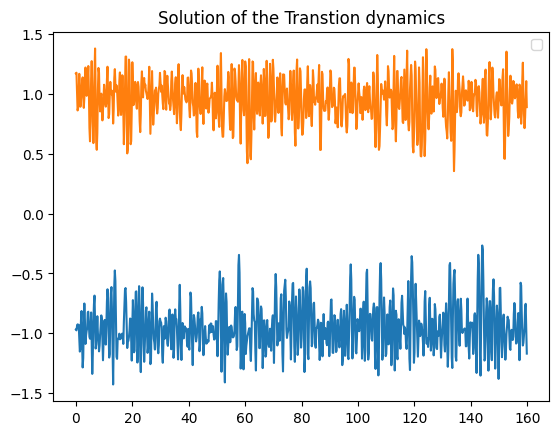

<Figure size 640x480 with 0 Axes>

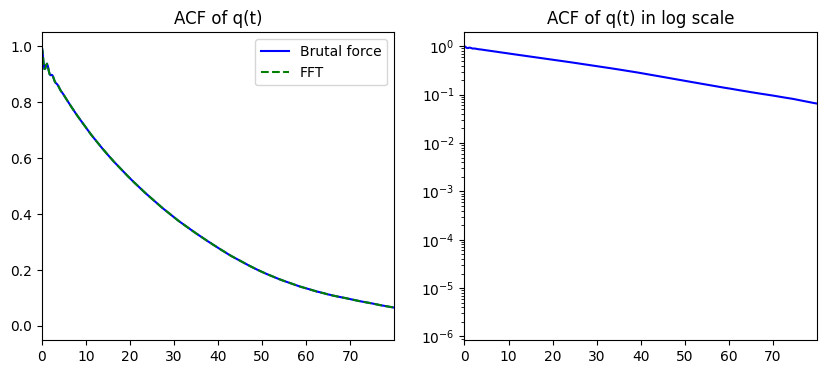

(400, 400) (400, 400)
CPU times: user 16.2 s, sys: 60.4 ms, total: 16.2 s
Wall time: 16.3 s


In [8]:
%%time

#### Generating SINN training data by solving the Langevin dynamics for the double-potential well

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad

def V_FPU(x,U0,x0,sigma):
    v=U0/x0**4*x**3+U0/x0**2*x      # FPU potential 
    return v

def V_double_well(x,U0,x0,sigma):
    v=4*U0/x0**4*x**3-4*U0/x0**2*x+sigma/(2*x0)         # Double-well potential 
    return v 

def integrand(x,U0,x0,beta,sigma):
    v=np.exp(-beta*(U0*(1-(x/x0)**2)**2+sigma*x/(2*x0)))        # integrand function
    return v 

def integrand2(x,U0,x0,beta,sigma):
    v=x**2*np.exp(-beta*(U0*(1-(x/x0)**2)**2+sigma*x/(2*x0)))        # integrand function
    return v 

######## Paraemters 
gamma=1                   # Coupling constant 
beta=1                    # Inverse temperature, i.e. T=1/beta
U0=4                      # Depth of the well 
x0=1                      # Basin of the well
sigma=0                   # Asymmetry of the well 
dt=0.001                  # Step-size of the SDE solver 
delta_t=0.2               # Step-size of the temporally coarse-grained path
batch = 400               # Batch size 
sec_length = 400          # Length of the input sequence 
I=quad(integrand,-10,10,args=(U0,x0,beta,sigma))
I2=quad(integrand2,-10,10,args=(U0,x0,beta,sigma))   # PDF normalization constant (partition function) 

### SDE solver (EM scheme), 
Time = 4*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
p_store = np.zeros([t_store.size+1,batch])
q_store = np.zeros([t_store.size+1,batch])
p=np.zeros((2,batch))
q=np.zeros((2,batch))
# solve SDE
j=1
for i in range(1,length):
     q[1,:] = q[0,:] + p[0,:]*dt
     p[1,:] = p[0,:] + (-V_double_well(q[0,:],U0,x0,sigma)-gamma*p[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     if i % gap ==0:            
            p_store[j,:]=p[1,:]
            q_store[j,:]=q[1,:]
            j=j+1
     p[0,:]=p[1,:]
     q[0,:]=q[1,:]

Toss=int(t_store.size/2)
p_store=p_store[Toss:-1,:]          
q_store=q_store[Toss:-1,:]         
print(p_store.shape,q_store.shape)




plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,i])
plt.legend()
plt.title("Solution of the Transtion dynamics")


## Calculating the acf for q(t) by brutal force
Traj1=q_store
T_acf=t_store[0:Traj1.shape[0]]
acf_u=StatLoss.acf(torch.from_numpy(Traj1.reshape(Traj1.shape[0], batch,1)),method='bruteforce')
acf_u_fft=StatLoss.acf(torch.from_numpy(Traj1.reshape(Traj1.shape[0], batch,1)))
corr_u=acf_u.mean(axis=1).detach().cpu().numpy()
corr_u_fft=acf_u_fft.mean(axis=1).detach().cpu().numpy()
plt.figure(2)      
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(T_acf, corr_u,'b',label='Brutal force')
axs[0].plot(T_acf, corr_u_fft,'g--',label='FFT')
axs[0].set_title('ACF of q(t)')
axs[0].set_xlim([0,T_acf[-1]/2])
axs[0].legend()
axs[1].semilogy(T_acf, corr_u,'b')
axs[1].semilogy(T_acf, np.zeros([Traj1.shape[0],1]),'r')
axs[1].set_title('ACF of q(t) in log scale')
axs[1].set_xlim([0,T_acf[-1]/2])
plt.show()


#####################  Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj=q_store[0:sec_length,:]
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
pdf_exact=np.exp(-beta*(U0*(1-(x/x0)**2)**2+sigma*x/(2*x0)))/I[0]
print(ini.shape, Traj.shape)




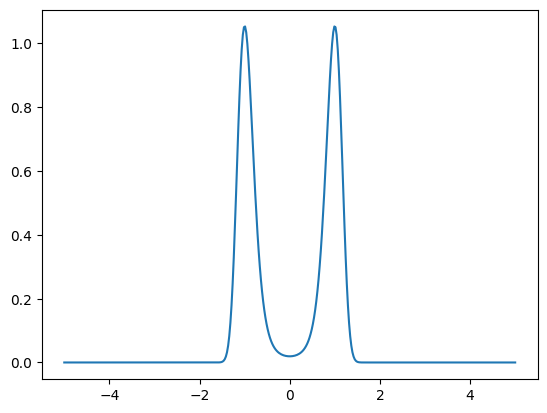

In [9]:
plt.plot(x,pdf_exact)

In [10]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)

Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch,1)).to(device)
pdf_exact = pdf_exact.astype(np.float32)
PDF_exact=torch.from_numpy(pdf_exact).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 1]) torch.float32


In [11]:
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_q2 = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)
loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_exact = make_loss('pdf', PDF_exact, lower=-5, upper=5, n=N, bw=None, device=device)

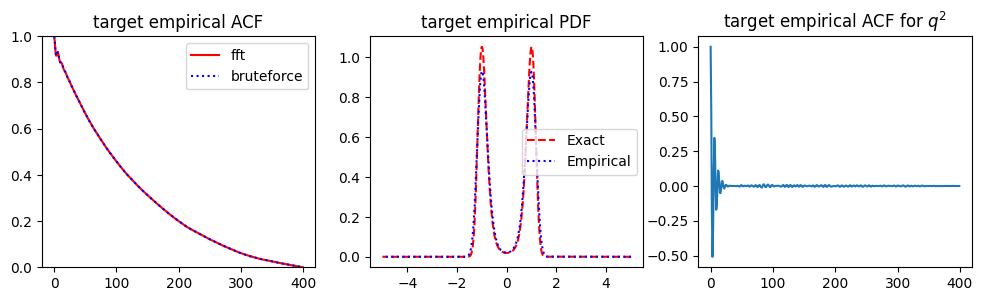

In [12]:
# Plotting target ACFs and PDF

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(loss_acf_fft._target.cpu(),'r', label='fft')
axs[0].plot(loss_acf_bruteforce._target.cpu(),'b:', label='bruteforce')
axs[0].set_title('target empirical ACF')
axs[0].set_ylim([0,1])

x_grid=-np.linspace(-5,5,num=sec_length)
axs[1].plot(x_grid,loss_pdf_exact._target.cpu(),'r--', label='Exact')
axs[1].plot(x_grid,loss_pdf_empirical._target.cpu(),'b:', label='Empirical')
# axs[1].plot(x_grid, np.exp(-beta*(U0*(1-(x_grid/x0)**2)**2+sigma*x_grid/(2*x0)))/I[0],'r--')
axs[1].set_title('target empirical PDF')
axs[2].plot(loss_acf_q2._target.cpu())
axs[2].set_title(r'target empirical ACF for $q^2$')
axs[0].legend()
axs[1].legend()
plt.show()

In [13]:
### Defining SINN model 
net = SINN_transformer(input_dimension=1, d_model=32, nhead=4, encoder_num_layers=2, decoder_num_layers=2, output_dimension=1).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [14]:
from prettytable import PrettyTable

In [15]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [16]:
count_parameters(net)

+-------------------------------------------------------------+------------+
|                           Modules                           | Parameters |
+-------------------------------------------------------------+------------+
|                       embedding.weight                      |     32     |
|                        embedding.bias                       |     32     |
|    transformer_encoder.layers.0.self_attn.in_proj_weight    |    3072    |
|     transformer_encoder.layers.0.self_attn.in_proj_bias     |     96     |
|    transformer_encoder.layers.0.self_attn.out_proj.weight   |    1024    |
|     transformer_encoder.layers.0.self_attn.out_proj.bias    |     32     |
|         transformer_encoder.layers.0.linear1.weight         |   65536    |
|          transformer_encoder.layers.0.linear1.bias          |    2048    |
|         transformer_encoder.layers.0.linear2.weight         |   65536    |
|          transformer_encoder.layers.0.linear2.bias          |     32     |

558689

In [17]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(sec_length, batch,1)).to(device)
    prediction = net(input,target)
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val = net(val_set, target)
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.259, 0.273
[50]-th step loss: 0.003, 0.003
[100]-th step loss: 0.003, 0.003
[150]-th step loss: 0.002, 0.003
[200]-th step loss: 0.002, 0.002
[250]-th step loss: 0.002, 0.002
[300]-th step loss: 0.002, 0.002
[350]-th step loss: 0.002, 0.002
[400]-th step loss: 0.002, 0.002
[450]-th step loss: 0.002, 0.002
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.002, 0.002
[600]-th step loss: 0.002, 0.002
[650]-th step loss: 0.002, 0.002
[700]-th step loss: 0.002, 0.002
[750]-th step loss: 0.002, 0.002
[800]-th step loss: 0.002, 0.002
[850]-th step loss: 0.002, 0.002
[900]-th step loss: 0.002, 0.002
[950]-th step loss: 0.002, 0.002
[1000]-th step loss: 0.002, 0.002
[1050]-th step loss: 0.002, 0.002
[1100]-th step loss: 0.002, 0.002
[1150]-th step loss: 0.002, 0.002
[1200]-th step loss: 0.002, 0.002
[1250]-th step loss: 0.002, 0.002
[1300]-th step loss: 0.002, 0.002
[1350]-th step loss: 0.002, 0.002
[1400]-th step loss: 0.002, 0.002
[1450]-th step loss: 0.002, 0.002
[15

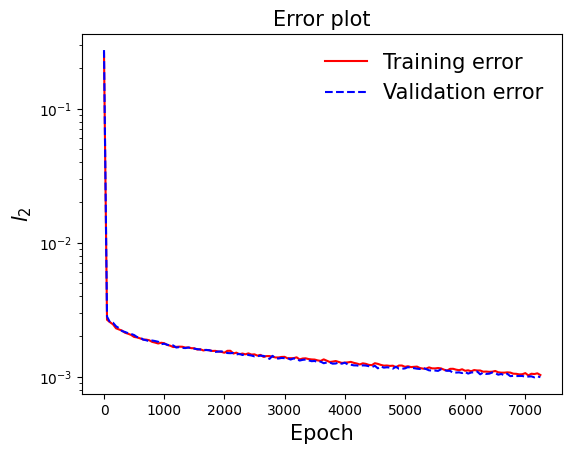

In [18]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_training_error.pdf", dpi=150)

In [19]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred= net(ran_input, target)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14af210e3700>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

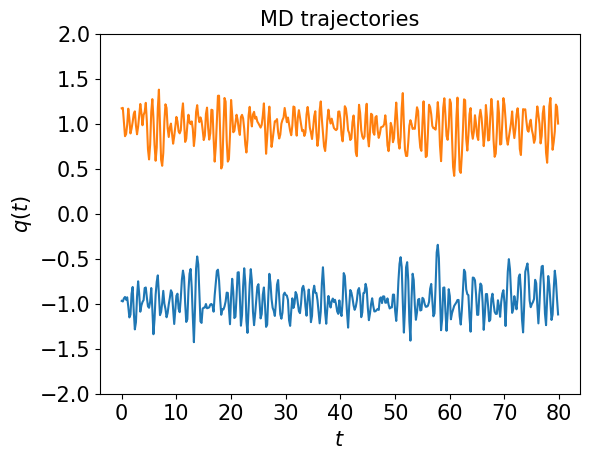

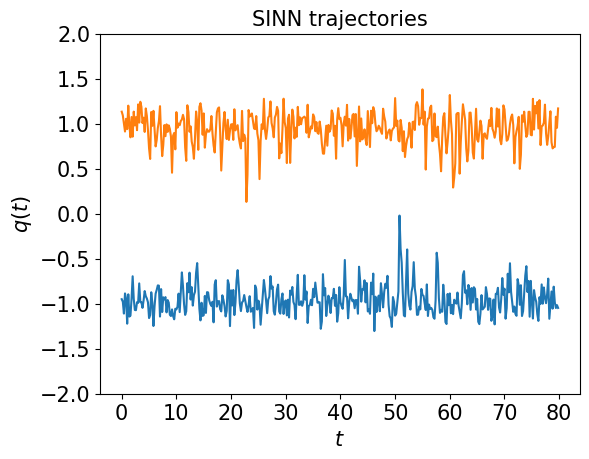

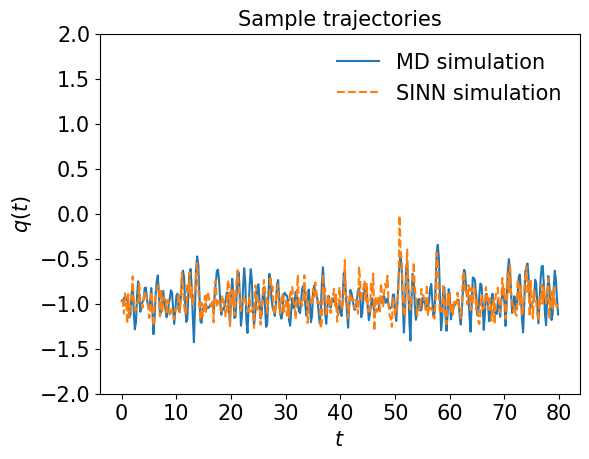

In [20]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

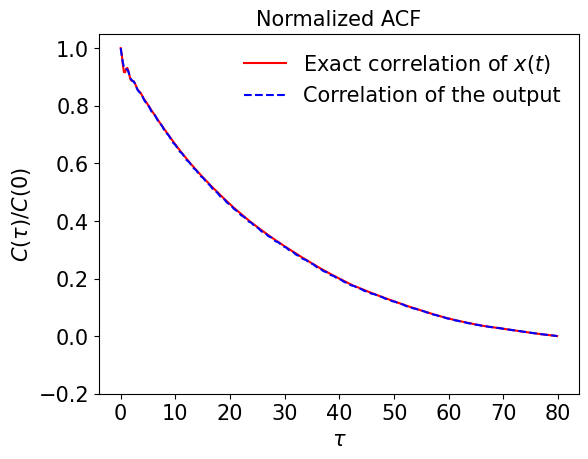

In [21]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

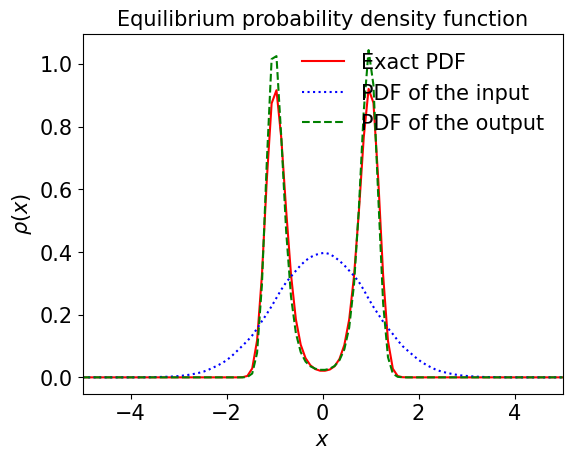

In [22]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

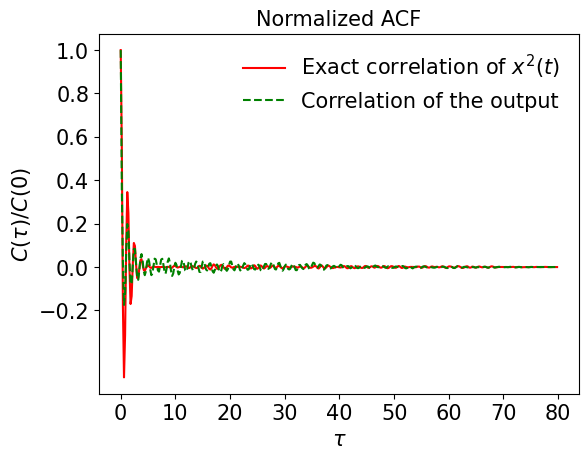

In [23]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf2.pdf", dpi=150)

In [24]:
torch.cuda.empty_cache()

In [25]:
import gc

del net #delete unnecessary variables 
gc.collect()

1193

In [26]:
### Defining SINN model 
net1 = SINN_transformer(input_dimension=1, d_model=32, nhead=4, encoder_num_layers=2, decoder_num_layers=2, output_dimension=1).to(device)
optimizer = optim.Adam(net1.parameters(), lr=1e-3)

In [27]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(sec_length, batch,1)).to(device)
    prediction = net1(input,target)
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val = net1(val_set, target)
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net1.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net1.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net1.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.266, 0.257
[50]-th step loss: 0.009, 0.008
[100]-th step loss: 0.008, 0.007
[150]-th step loss: 0.008, 0.006
[200]-th step loss: 0.007, 0.006
[250]-th step loss: 0.006, 0.005
[300]-th step loss: 0.006, 0.005
[350]-th step loss: 0.006, 0.004
[400]-th step loss: 0.007, 0.004
[450]-th step loss: 0.006, 0.004
[500]-th step loss: 0.007, 0.004
[550]-th step loss: 0.006, 0.004
[600]-th step loss: 0.006, 0.004
[650]-th step loss: 0.006, 0.004
[700]-th step loss: 0.006, 0.003
[750]-th step loss: 0.006, 0.003
[800]-th step loss: 0.006, 0.003
[850]-th step loss: 0.006, 0.003
[900]-th step loss: 0.005, 0.003
[950]-th step loss: 0.006, 0.003
[1000]-th step loss: 0.006, 0.003
[1050]-th step loss: 0.006, 0.003
[1100]-th step loss: 0.005, 0.003
[1150]-th step loss: 0.006, 0.003
[1200]-th step loss: 0.005, 0.003
[1250]-th step loss: 0.006, 0.003
[1300]-th step loss: 0.005, 0.003
[1350]-th step loss: 0.006, 0.003
[1400]-th step loss: 0.002, 0.002
[1450]-th step loss: 0.002, 0.002
[15

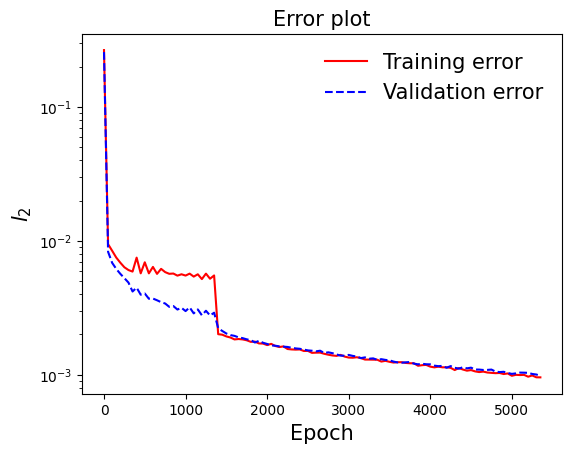

In [28]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [29]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred= net1(ran_input, target)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14af20410a00>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

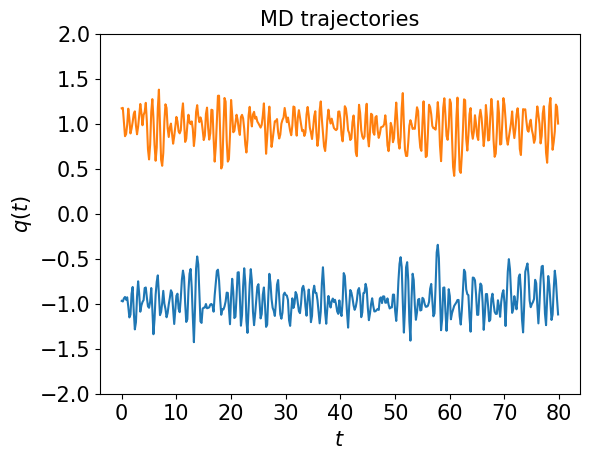

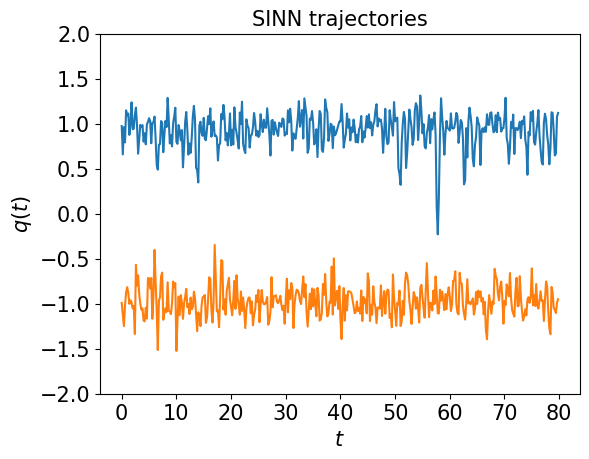

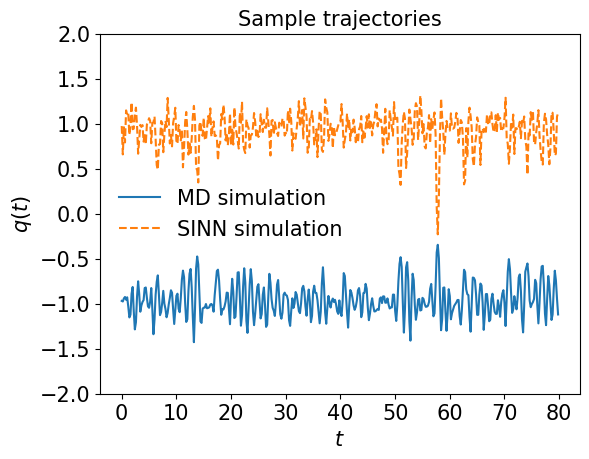

In [30]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

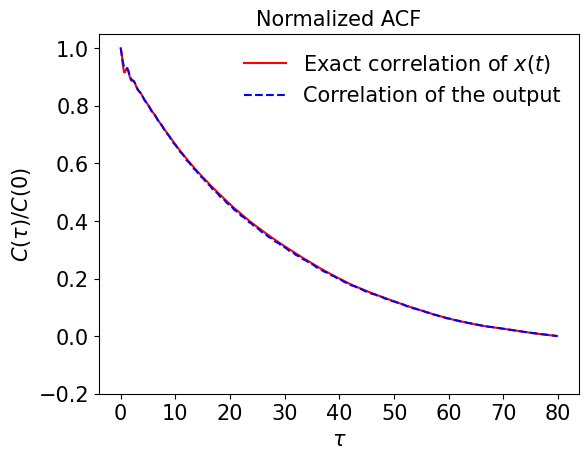

In [31]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

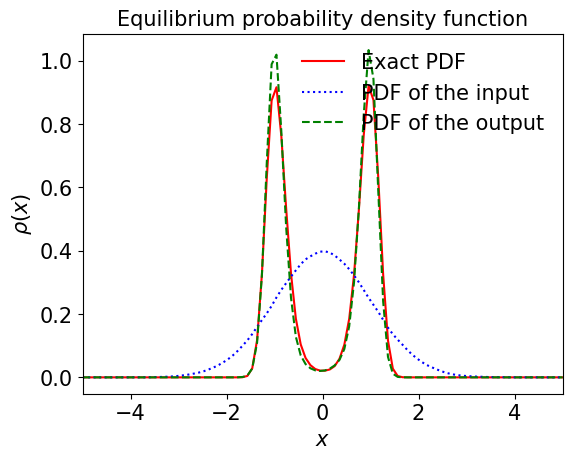

In [32]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

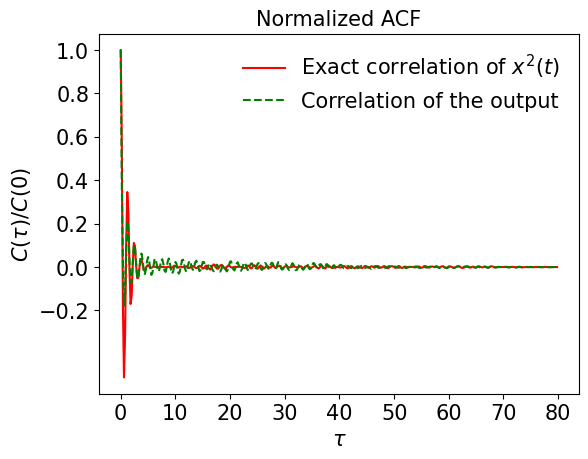

In [33]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf2.pdf", dpi=150)

In [34]:
del net1 #delete unnecessary variables 
gc.collect()

2273

In [35]:
### Defining SINN model 
net2 = SINN_transformer(input_dimension=1, d_model=32, nhead=4, encoder_num_layers=2, decoder_num_layers=2, output_dimension=1).to(device)
optimizer = optim.Adam(net2.parameters(), lr=1e-3)

In [36]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(sec_length, batch,1)).to(device)
    prediction = net2(input,target)
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val = net2(val_set, target)
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net2.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net2.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net2.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.149, 0.279
[50]-th step loss: 0.004, 0.004
[100]-th step loss: 0.003, 0.003
[150]-th step loss: 0.003, 0.003
[200]-th step loss: 0.003, 0.003
[250]-th step loss: 0.002, 0.002
[300]-th step loss: 0.002, 0.002
[350]-th step loss: 0.002, 0.002
[400]-th step loss: 0.002, 0.002
[450]-th step loss: 0.002, 0.002
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.002, 0.002
[600]-th step loss: 0.002, 0.002
[650]-th step loss: 0.002, 0.002
[700]-th step loss: 0.002, 0.002
[750]-th step loss: 0.002, 0.002
[800]-th step loss: 0.002, 0.002
[850]-th step loss: 0.002, 0.002
[900]-th step loss: 0.002, 0.002
[950]-th step loss: 0.002, 0.002
[1000]-th step loss: 0.002, 0.002
[1050]-th step loss: 0.002, 0.002
[1100]-th step loss: 0.002, 0.002
[1150]-th step loss: 0.002, 0.002
[1200]-th step loss: 0.002, 0.002
[1250]-th step loss: 0.002, 0.002
[1300]-th step loss: 0.002, 0.002
[1350]-th step loss: 0.002, 0.002
[1400]-th step loss: 0.002, 0.002
[1450]-th step loss: 0.002, 0.002
[15

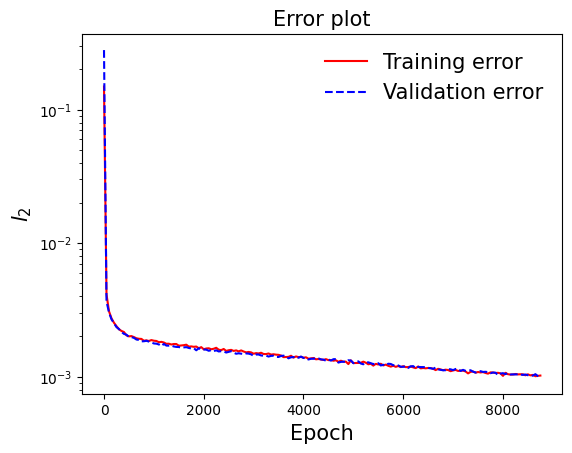

In [37]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [38]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred= net2(ran_input, target)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14af2057a100>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

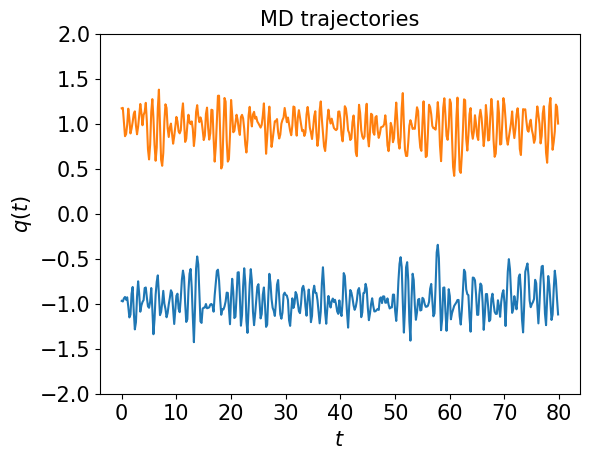

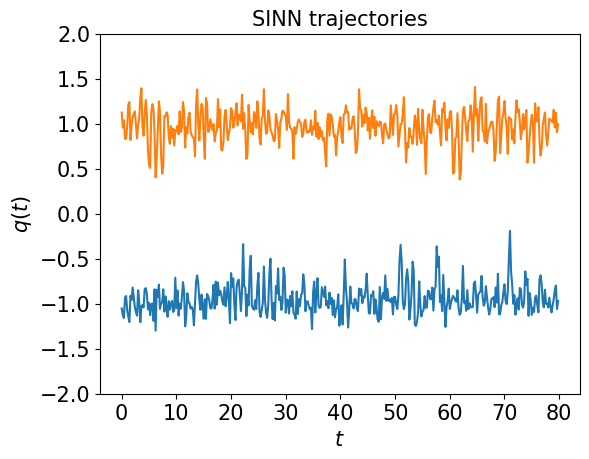

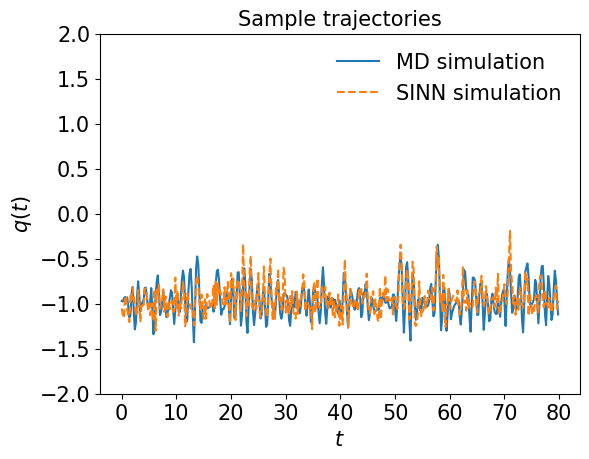

In [39]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

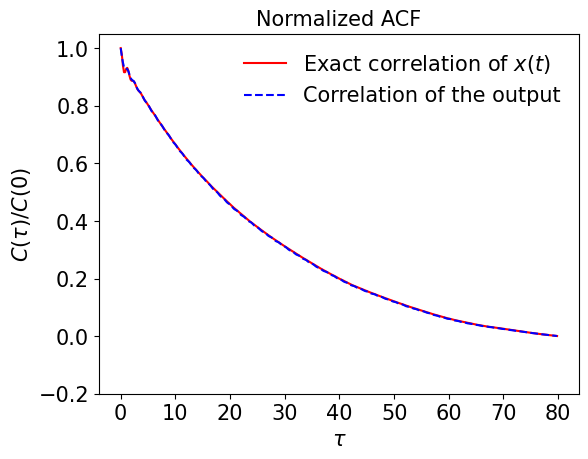

In [40]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

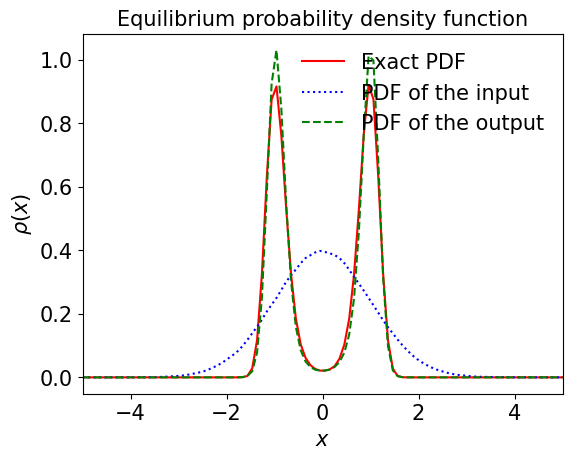

In [41]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

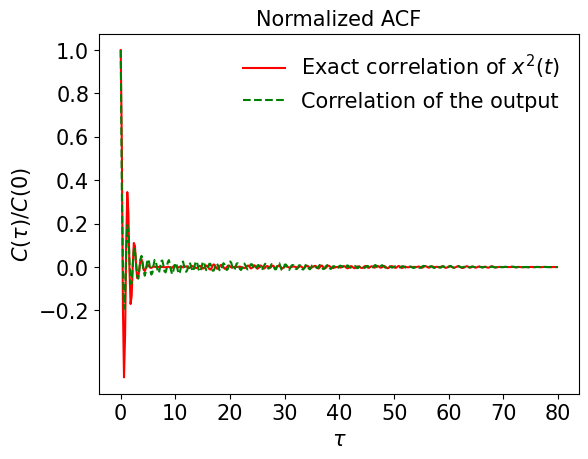

In [42]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [43]:
del net2 #delete unnecessary variables 
gc.collect()

9305

In [44]:
### Defining SINN model 
net3 = SINN_transformer(input_dimension=1, d_model=32, nhead=4, encoder_num_layers=2, decoder_num_layers=2, output_dimension=1).to(device)
optimizer = optim.Adam(net3.parameters(), lr=1e-3)

In [45]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(sec_length, batch,1)).to(device)
    prediction = net3(input,target)
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val = net3(val_set, target)
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net3.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net3.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net3.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.165, 0.246
[50]-th step loss: 0.003, 0.003
[100]-th step loss: 0.003, 0.002
[150]-th step loss: 0.002, 0.002
[200]-th step loss: 0.002, 0.002
[250]-th step loss: 0.002, 0.002
[300]-th step loss: 0.002, 0.002
[350]-th step loss: 0.002, 0.002
[400]-th step loss: 0.002, 0.002
[450]-th step loss: 0.002, 0.002
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.002, 0.002
[600]-th step loss: 0.002, 0.002
[650]-th step loss: 0.002, 0.002
[700]-th step loss: 0.002, 0.002
[750]-th step loss: 0.002, 0.002
[800]-th step loss: 0.002, 0.002
[850]-th step loss: 0.002, 0.002
[900]-th step loss: 0.002, 0.002
[950]-th step loss: 0.002, 0.002
[1000]-th step loss: 0.002, 0.002
[1050]-th step loss: 0.002, 0.002
[1100]-th step loss: 0.002, 0.002
[1150]-th step loss: 0.002, 0.002
[1200]-th step loss: 0.002, 0.002
[1250]-th step loss: 0.002, 0.002
[1300]-th step loss: 0.002, 0.002
[1350]-th step loss: 0.002, 0.002
[1400]-th step loss: 0.002, 0.002
[1450]-th step loss: 0.002, 0.002
[15

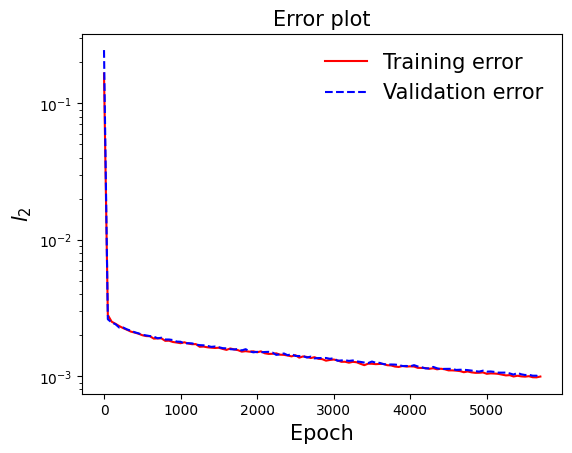

In [46]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [47]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred= net3(ran_input, target)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14ad13b12b80>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

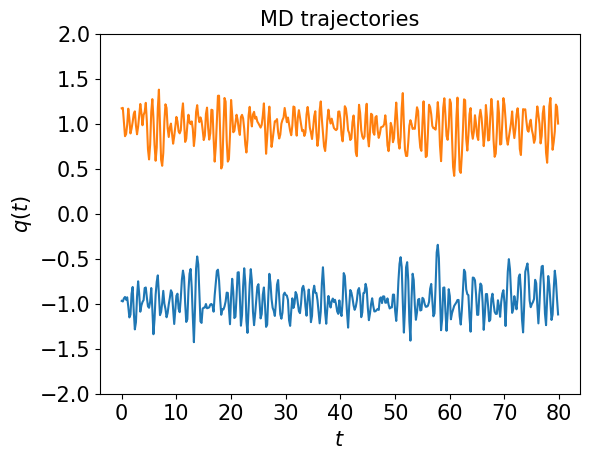

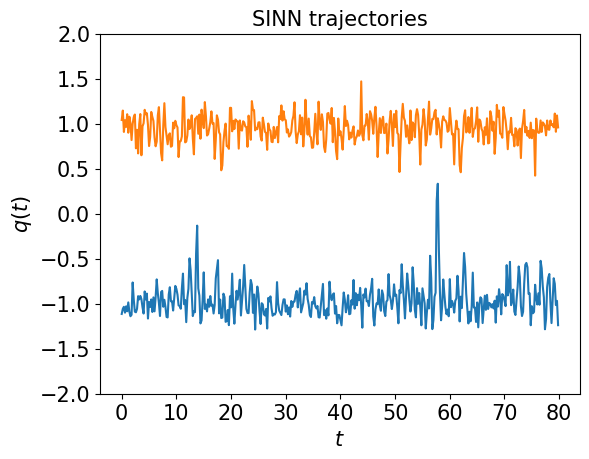

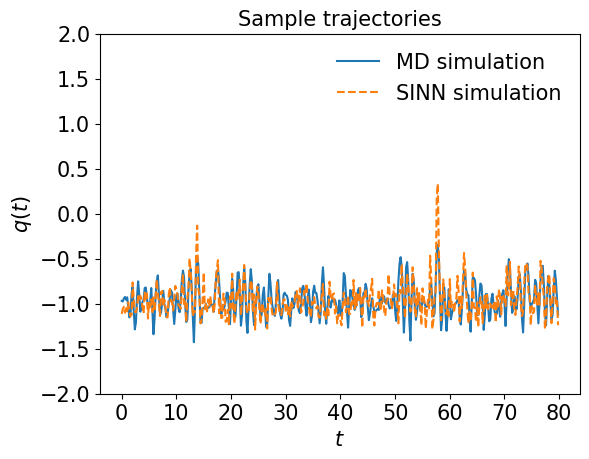

In [48]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

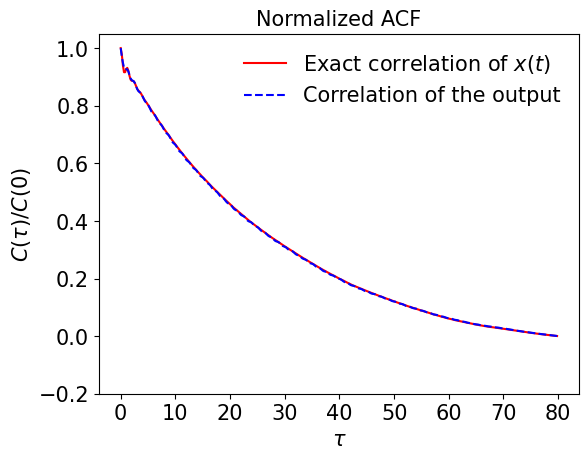

In [49]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

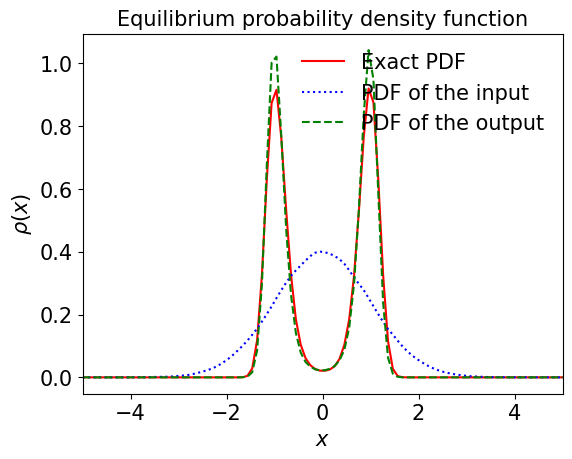

In [50]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

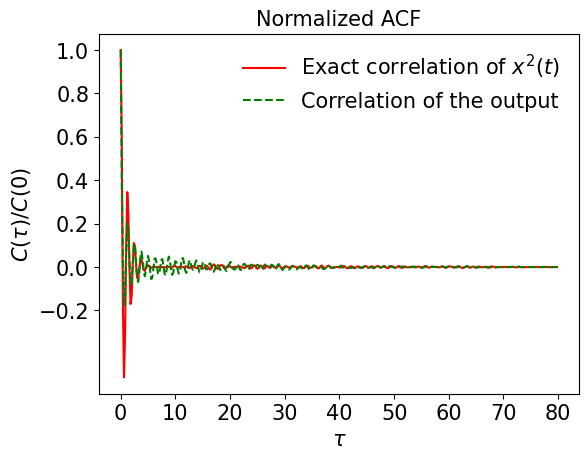

In [51]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [52]:
del net3 #delete unnecessary variables 
gc.collect()

10576

In [53]:
### Defining SINN model 
net4 = SINN_transformer(input_dimension=1, d_model=32, nhead=4, encoder_num_layers=2, decoder_num_layers=2, output_dimension=1).to(device)
optimizer = optim.Adam(net4.parameters(), lr=1e-3)

In [54]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(sec_length, batch,1)).to(device)
    prediction = net4(input,target)
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val = net4(val_set, target)
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net4.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net4.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net4.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.226, 0.246
[50]-th step loss: 0.006, 0.006
[100]-th step loss: 0.004, 0.005
[150]-th step loss: 0.004, 0.005
[200]-th step loss: 0.003, 0.003
[250]-th step loss: 0.002, 0.002
[300]-th step loss: 0.002, 0.002
[350]-th step loss: 0.002, 0.002
[400]-th step loss: 0.002, 0.002
[450]-th step loss: 0.002, 0.002
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.002, 0.002
[600]-th step loss: 0.002, 0.002
[650]-th step loss: 0.002, 0.002
[700]-th step loss: 0.002, 0.002
[750]-th step loss: 0.002, 0.002
[800]-th step loss: 0.002, 0.002
[850]-th step loss: 0.002, 0.002
[900]-th step loss: 0.002, 0.002
[950]-th step loss: 0.002, 0.002
[1000]-th step loss: 0.002, 0.002
[1050]-th step loss: 0.002, 0.002
[1100]-th step loss: 0.002, 0.002
[1150]-th step loss: 0.002, 0.002
[1200]-th step loss: 0.002, 0.002
[1250]-th step loss: 0.002, 0.002
[1300]-th step loss: 0.002, 0.002
[1350]-th step loss: 0.002, 0.002
[1400]-th step loss: 0.002, 0.002
[1450]-th step loss: 0.002, 0.002
[15

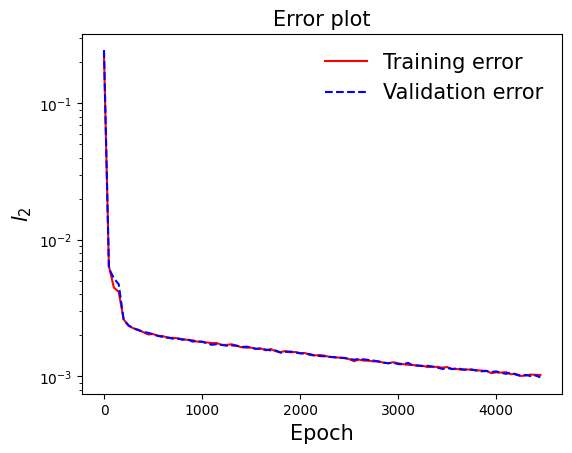

In [55]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [56]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred= net4(ran_input, target)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14ad13787400>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

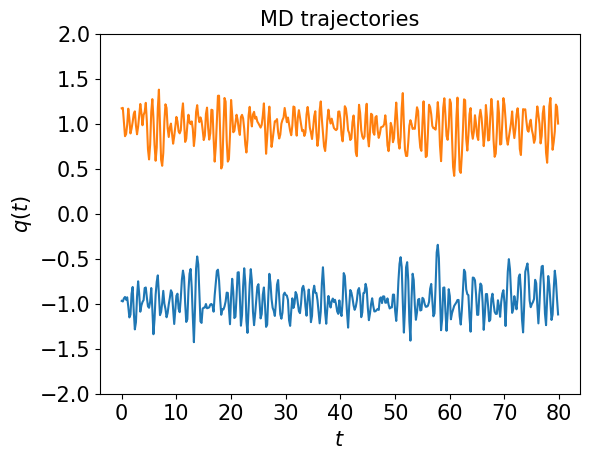

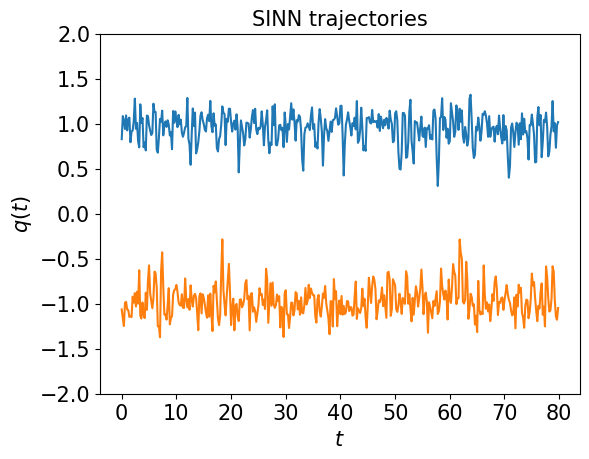

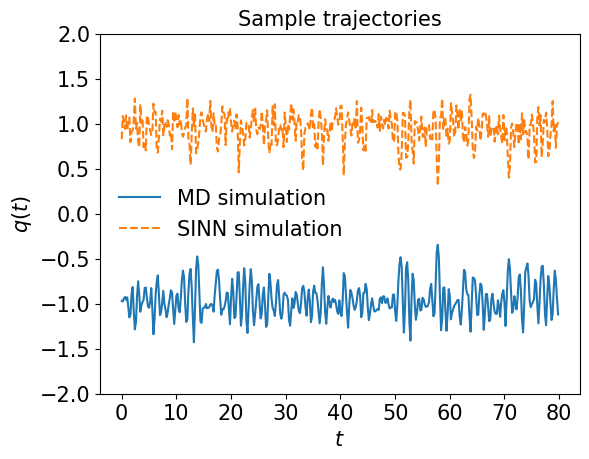

In [57]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

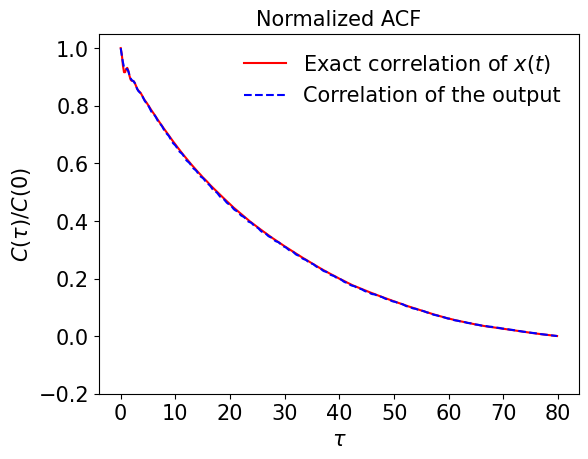

In [58]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

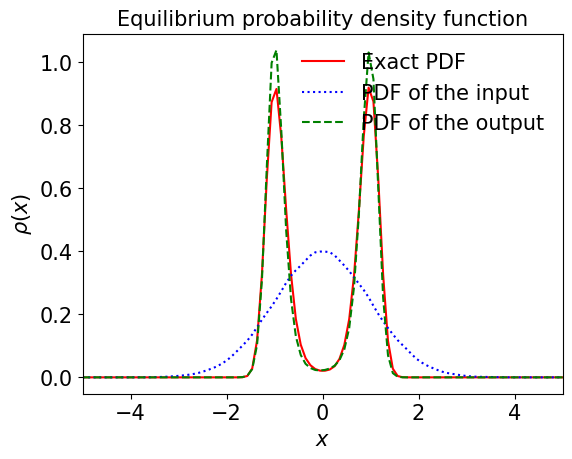

In [59]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

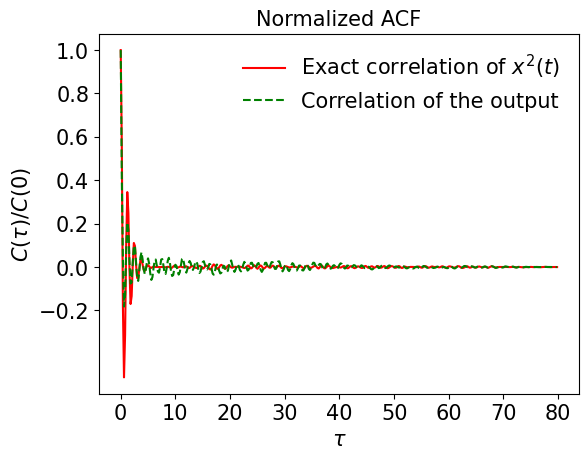

In [60]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [61]:
del net4 #delete unnecessary variables 
gc.collect()

11040

In [62]:
### Defining SINN model 
net5 = SINN_transformer(input_dimension=1, d_model=32, nhead=4, encoder_num_layers=2, decoder_num_layers=2, output_dimension=1).to(device)
optimizer = optim.Adam(net5.parameters(), lr=1e-3)

In [63]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(sec_length, batch,1)).to(device)
    prediction = net5(input,target)
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val = net5(val_set, target)
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net5.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net5.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net5.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.195, 0.213
[50]-th step loss: 0.004, 0.004
[100]-th step loss: 0.003, 0.003
[150]-th step loss: 0.003, 0.003
[200]-th step loss: 0.003, 0.003
[250]-th step loss: 0.003, 0.003
[300]-th step loss: 0.002, 0.002
[350]-th step loss: 0.002, 0.002
[400]-th step loss: 0.002, 0.002
[450]-th step loss: 0.002, 0.002
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.002, 0.002
[600]-th step loss: 0.002, 0.002
[650]-th step loss: 0.002, 0.002
[700]-th step loss: 0.002, 0.002
[750]-th step loss: 0.002, 0.002
[800]-th step loss: 0.002, 0.002
[850]-th step loss: 0.002, 0.002
[900]-th step loss: 0.002, 0.002
[950]-th step loss: 0.002, 0.002
[1000]-th step loss: 0.002, 0.002
[1050]-th step loss: 0.002, 0.002
[1100]-th step loss: 0.002, 0.002
[1150]-th step loss: 0.002, 0.002
[1200]-th step loss: 0.002, 0.002
[1250]-th step loss: 0.002, 0.002
[1300]-th step loss: 0.002, 0.002
[1350]-th step loss: 0.002, 0.001
[1400]-th step loss: 0.001, 0.002
[1450]-th step loss: 0.002, 0.002
[15

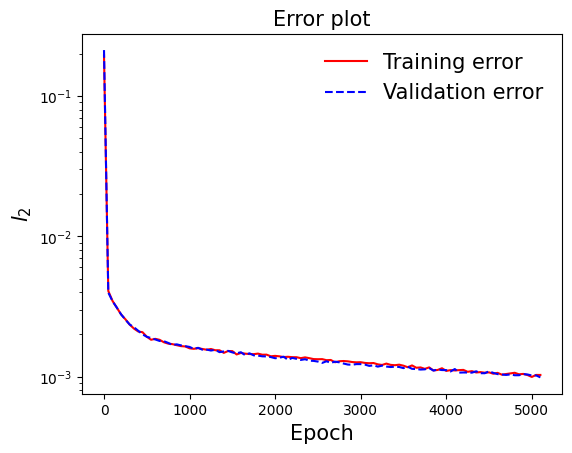

In [64]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [65]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred= net5(ran_input, target)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14ad13404df0>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

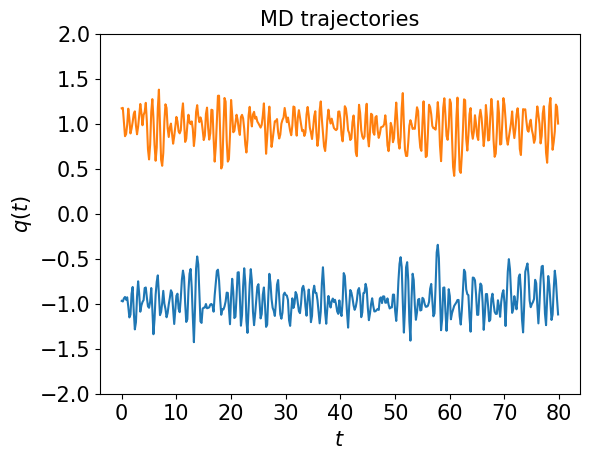

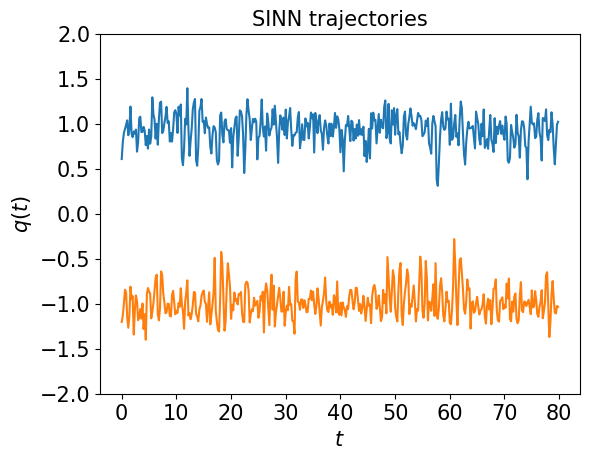

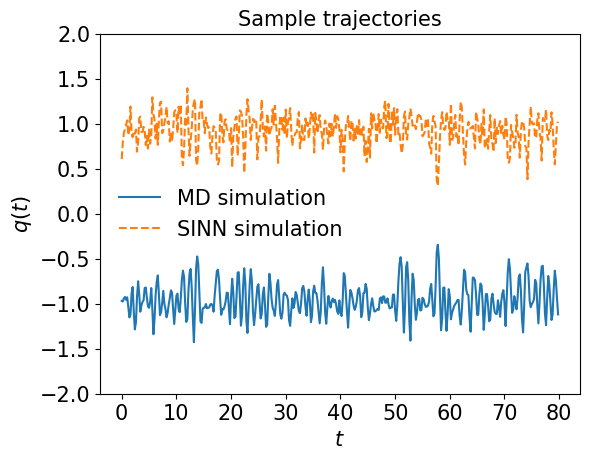

In [66]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

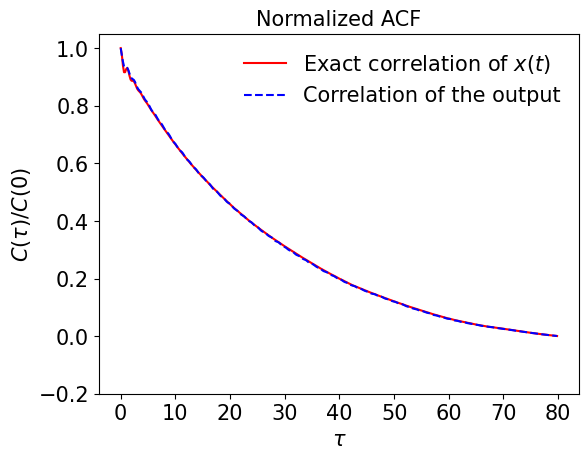

In [67]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

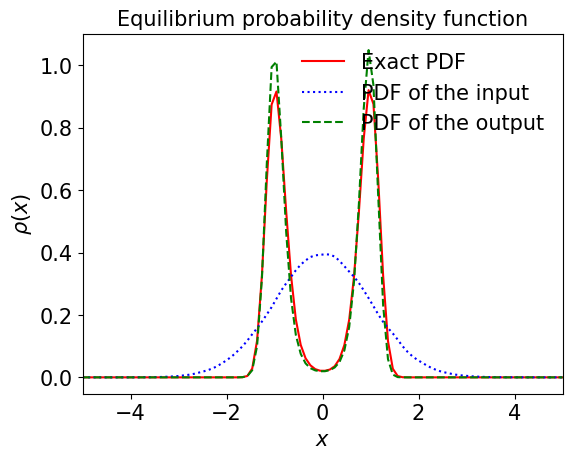

In [68]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

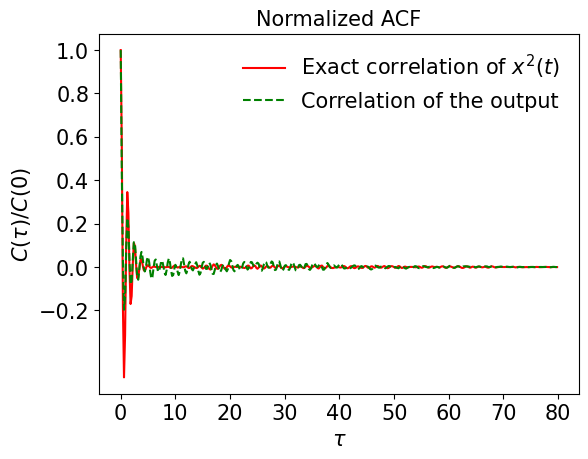

In [69]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [70]:
del net5 #delete unnecessary variables 
gc.collect()

10455

In [71]:
### Defining SINN model 
net6 = SINN_transformer(input_dimension=1, d_model=32, nhead=4, encoder_num_layers=2, decoder_num_layers=2, output_dimension=1).to(device)
optimizer = optim.Adam(net6.parameters(), lr=1e-3)

In [72]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(sec_length, batch,1)).to(device)
    prediction = net6(input,target)
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val = net6(val_set, target)
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net6.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net6.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net6.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.322, 0.222
[50]-th step loss: 0.002, 0.002
[100]-th step loss: 0.002, 0.002
[150]-th step loss: 0.002, 0.002
[200]-th step loss: 0.002, 0.002
[250]-th step loss: 0.002, 0.002
[300]-th step loss: 0.002, 0.002
[350]-th step loss: 0.002, 0.002
[400]-th step loss: 0.002, 0.002
[450]-th step loss: 0.002, 0.002
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.002, 0.002
[600]-th step loss: 0.002, 0.002
[650]-th step loss: 0.002, 0.002
[700]-th step loss: 0.002, 0.002
[750]-th step loss: 0.002, 0.002
[800]-th step loss: 0.002, 0.002
[850]-th step loss: 0.002, 0.002
[900]-th step loss: 0.002, 0.002
[950]-th step loss: 0.002, 0.002
[1000]-th step loss: 0.002, 0.002
[1050]-th step loss: 0.002, 0.002
[1100]-th step loss: 0.002, 0.002
[1150]-th step loss: 0.002, 0.002
[1200]-th step loss: 0.001, 0.002
[1250]-th step loss: 0.002, 0.002
[1300]-th step loss: 0.002, 0.001
[1350]-th step loss: 0.002, 0.001
[1400]-th step loss: 0.001, 0.001
[1450]-th step loss: 0.001, 0.001
[15

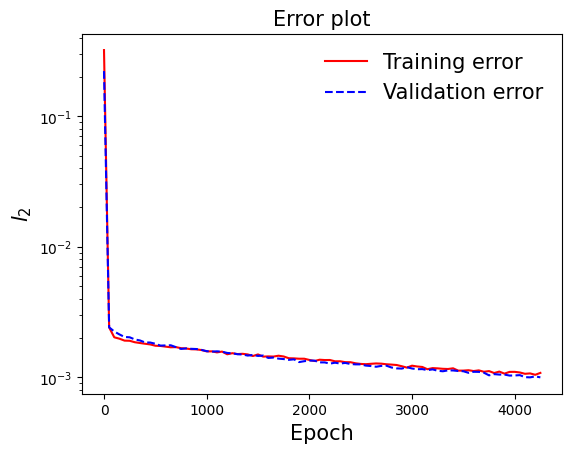

In [73]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [74]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred= net6(ran_input, target)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14ad124f5430>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

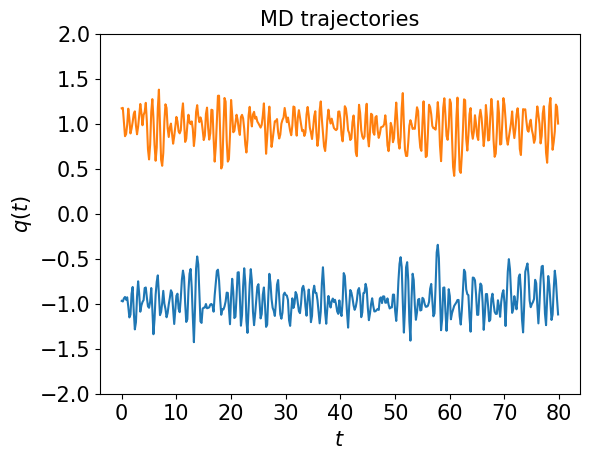

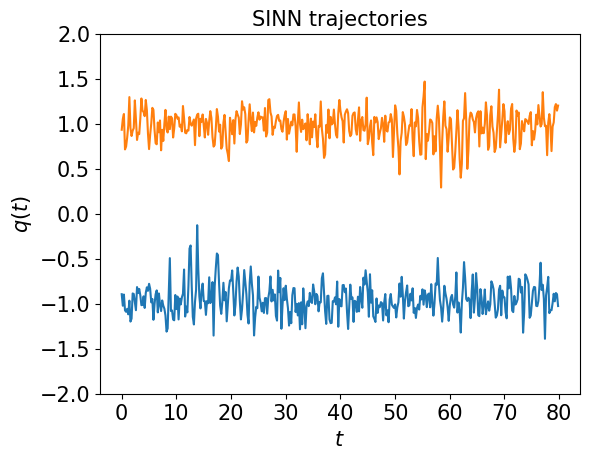

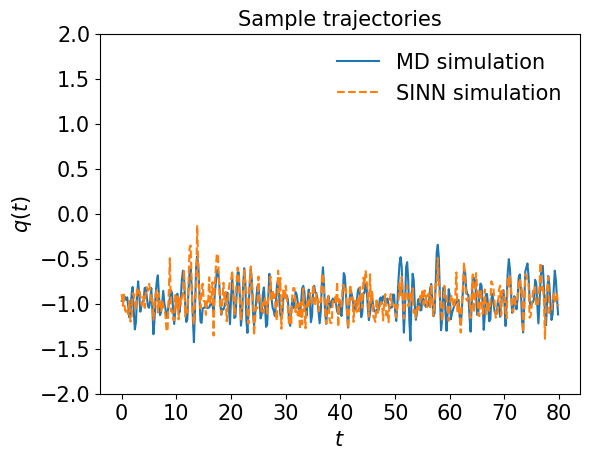

In [75]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

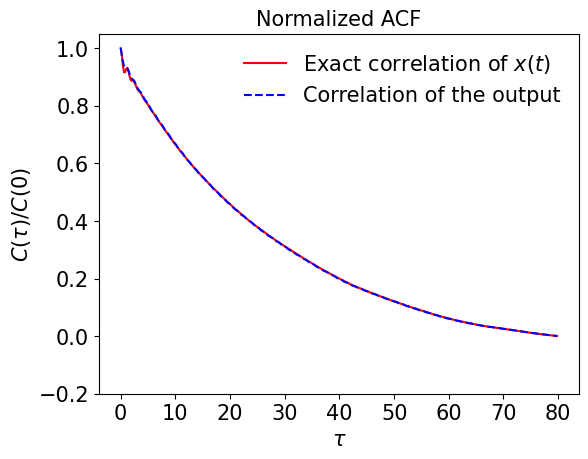

In [76]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

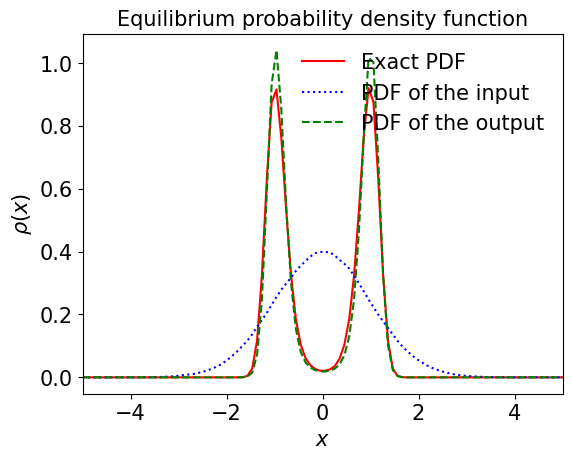

In [77]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

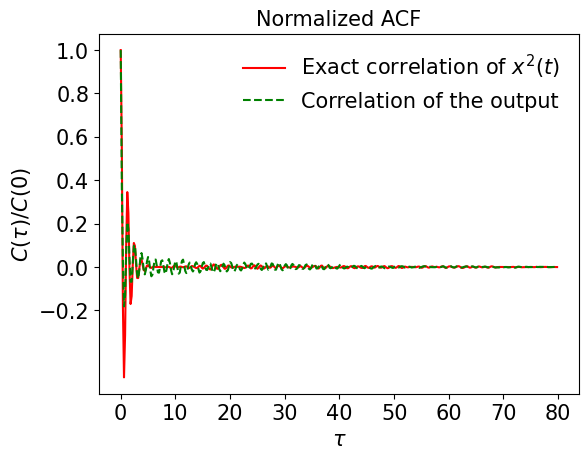

In [78]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [79]:
del net6 #delete unnecessary variables 
gc.collect()

10774

In [80]:
### Defining SINN model 
net7 = SINN_transformer(input_dimension=1, d_model=32, nhead=4, encoder_num_layers=2, decoder_num_layers=2, output_dimension=1).to(device)
optimizer = optim.Adam(net7.parameters(), lr=1e-3)

In [81]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(sec_length, batch,1)).to(device)
    prediction = net7(input,target)
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val = net7(val_set, target)
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net7.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net7.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net7.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.233, 0.102
[50]-th step loss: 0.007, 0.005
[100]-th step loss: 0.003, 0.003
[150]-th step loss: 0.003, 0.003
[200]-th step loss: 0.002, 0.002
[250]-th step loss: 0.002, 0.002
[300]-th step loss: 0.002, 0.002
[350]-th step loss: 0.002, 0.002
[400]-th step loss: 0.002, 0.002
[450]-th step loss: 0.002, 0.002
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.002, 0.002
[600]-th step loss: 0.002, 0.002
[650]-th step loss: 0.002, 0.002
[700]-th step loss: 0.002, 0.002
[750]-th step loss: 0.002, 0.002
[800]-th step loss: 0.002, 0.002
[850]-th step loss: 0.002, 0.002
[900]-th step loss: 0.002, 0.002
[950]-th step loss: 0.002, 0.002
[1000]-th step loss: 0.002, 0.002
[1050]-th step loss: 0.002, 0.002
[1100]-th step loss: 0.002, 0.002
[1150]-th step loss: 0.002, 0.002
[1200]-th step loss: 0.002, 0.002
[1250]-th step loss: 0.002, 0.002
[1300]-th step loss: 0.002, 0.002
[1350]-th step loss: 0.002, 0.002
[1400]-th step loss: 0.002, 0.002
[1450]-th step loss: 0.002, 0.002
[15

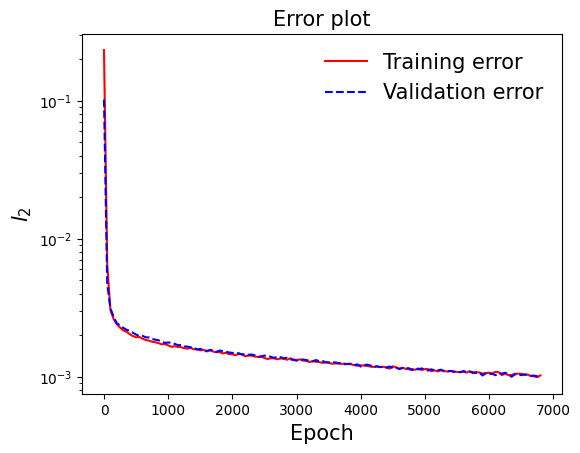

In [82]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [83]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred= net7(ran_input, target)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14ad12200b50>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

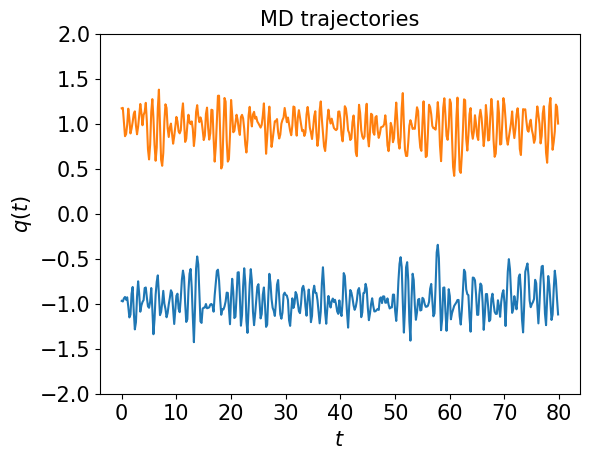

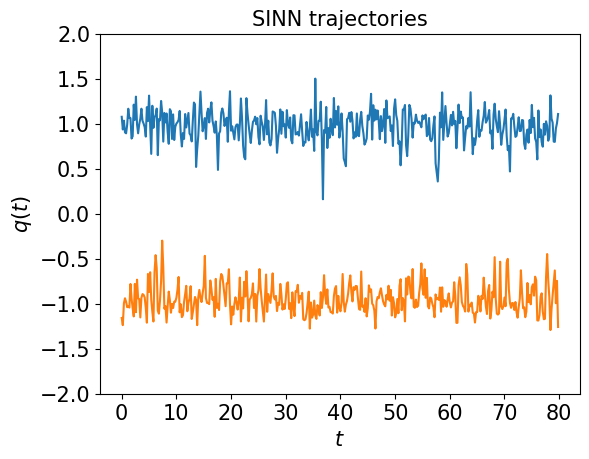

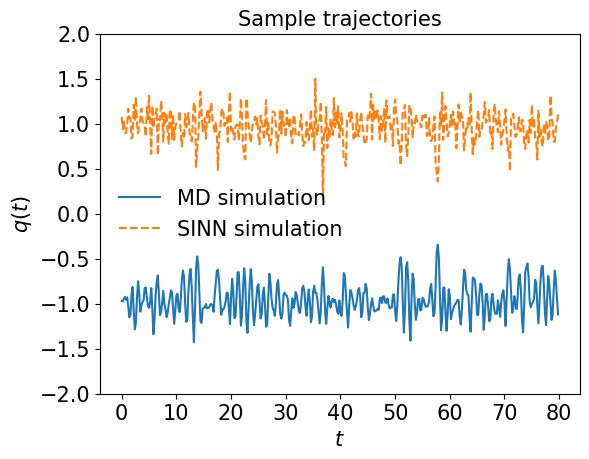

In [84]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

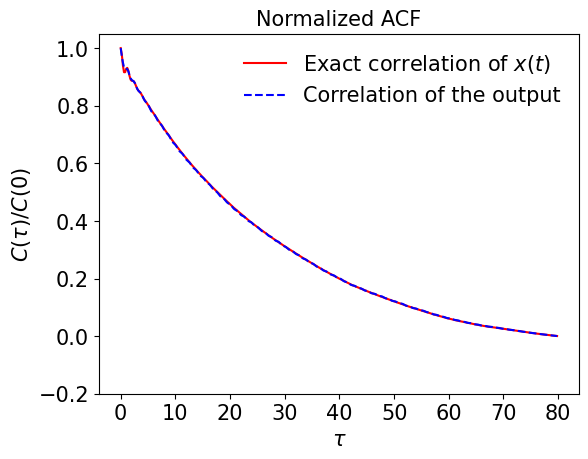

In [85]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

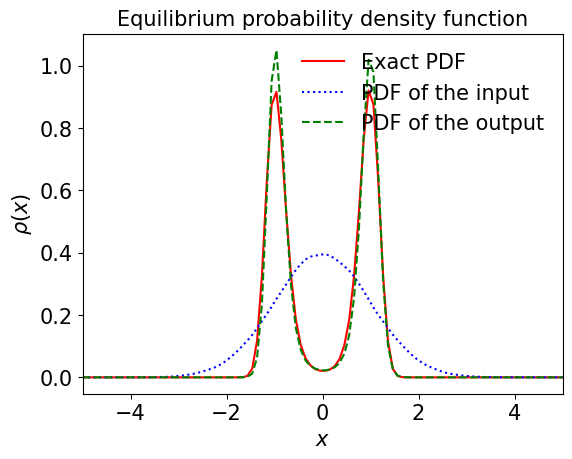

In [86]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

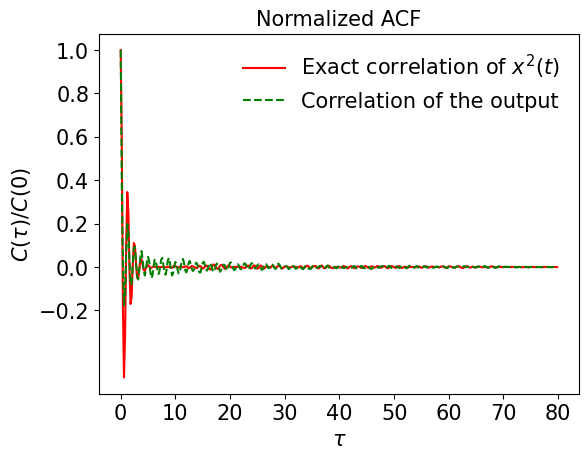

In [87]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [88]:
del net7 #delete unnecessary variables 
gc.collect()

9891

In [89]:
### Defining SINN model 
net8 =SINN_transformer(input_dimension=1, d_model=32, nhead=4, encoder_num_layers=2, decoder_num_layers=2, output_dimension=1).to(device)
optimizer = optim.Adam(net8.parameters(), lr=1e-3)

In [90]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(sec_length, batch,1)).to(device)
    prediction = net8(input,target)
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val = net8(val_set, target)
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net8.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net8.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net8.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.273, 0.199
[50]-th step loss: 0.004, 0.005
[100]-th step loss: 0.003, 0.003
[150]-th step loss: 0.003, 0.003
[200]-th step loss: 0.003, 0.003
[250]-th step loss: 0.002, 0.002
[300]-th step loss: 0.002, 0.002
[350]-th step loss: 0.002, 0.002
[400]-th step loss: 0.002, 0.002
[450]-th step loss: 0.002, 0.002
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.002, 0.002
[600]-th step loss: 0.002, 0.002
[650]-th step loss: 0.002, 0.002
[700]-th step loss: 0.002, 0.002
[750]-th step loss: 0.002, 0.002
[800]-th step loss: 0.002, 0.002
[850]-th step loss: 0.002, 0.002
[900]-th step loss: 0.002, 0.002
[950]-th step loss: 0.002, 0.002
[1000]-th step loss: 0.002, 0.002
[1050]-th step loss: 0.002, 0.002
[1100]-th step loss: 0.002, 0.002
[1150]-th step loss: 0.002, 0.002
[1200]-th step loss: 0.002, 0.002
[1250]-th step loss: 0.002, 0.002
[1300]-th step loss: 0.002, 0.002
[1350]-th step loss: 0.002, 0.002
[1400]-th step loss: 0.002, 0.002
[1450]-th step loss: 0.002, 0.002
[15

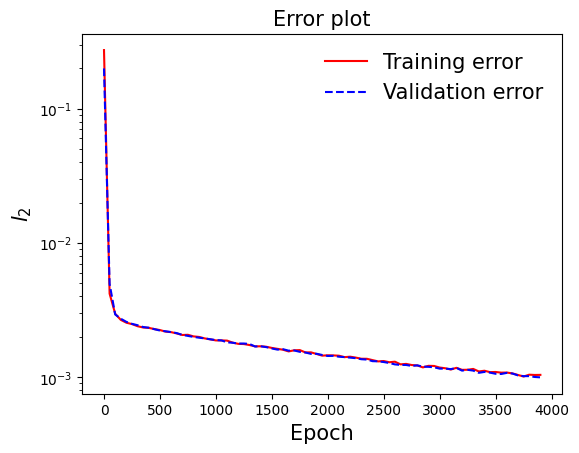

In [91]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [92]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred= net8(ran_input, target)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14ad11de97c0>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

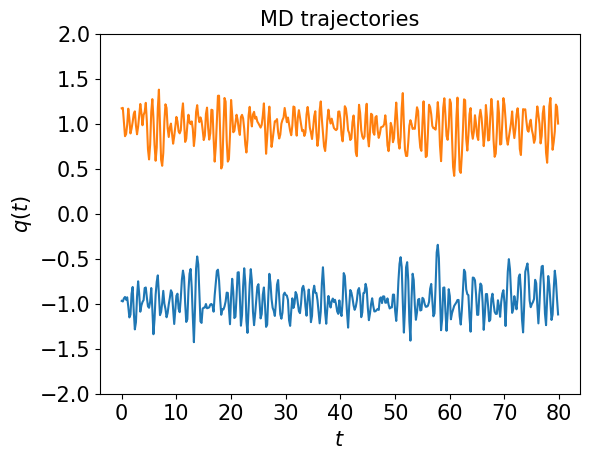

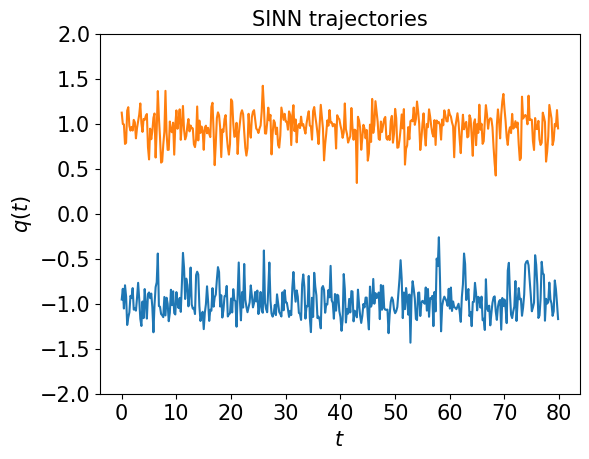

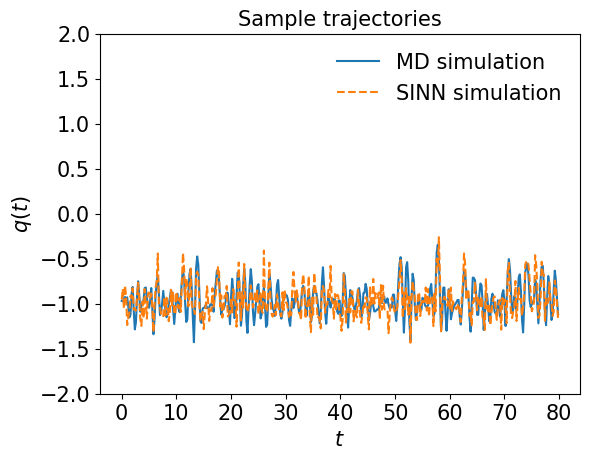

In [93]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

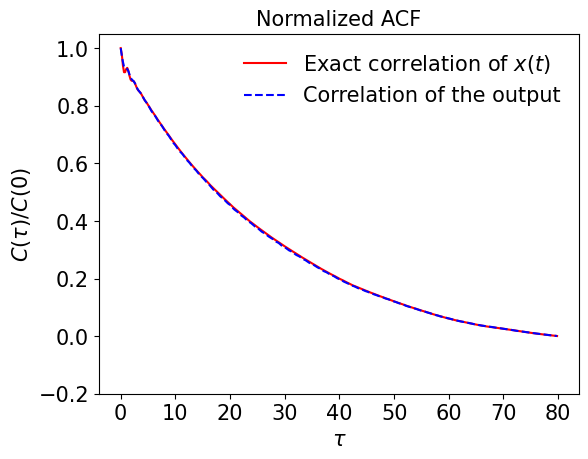

In [94]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

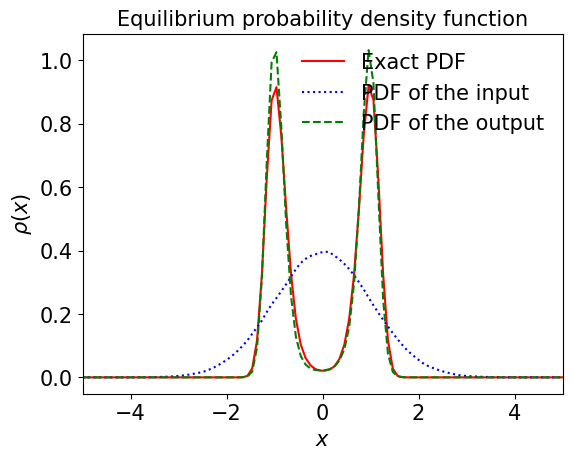

In [95]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

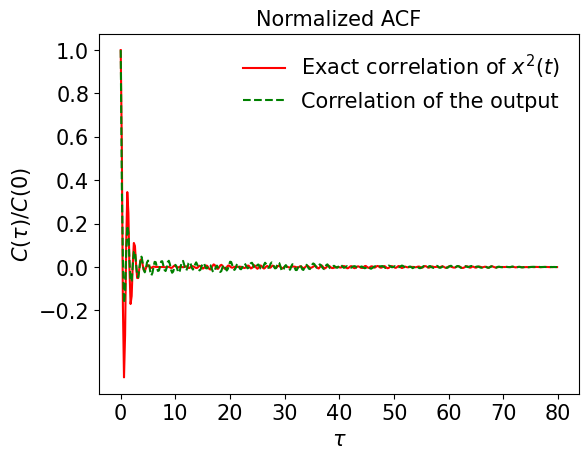

In [96]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [97]:
del net8 #delete unnecessary variables 
gc.collect()

11135

In [98]:
### Defining SINN model 
net9 = SINN_transformer(input_dimension=1, d_model=32, nhead=4, encoder_num_layers=2, decoder_num_layers=2, output_dimension=1).to(device)
optimizer = optim.Adam(net9.parameters(), lr=1e-3)

In [99]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(sec_length, batch,1)).to(device)
    prediction = net9(input,target)
    loss = loss_acf_bruteforce(prediction) + loss_pdf_exact(prediction) + loss_acf_q2(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val = net9(val_set, target)
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_exact(pred_val) + loss_acf_q2(pred_val**2)
            loss_val_acf = loss_acf_fft(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.05 and loss_val<=0.05:
        optimizer = optim.Adam(net9.parameters(), lr=0.3*1e-3) 
    if loss<=0.01 and loss_val<=0.01:
        optimizer = optim.Adam(net9.parameters(), lr=1e-4)    
    if loss<=0.005 and loss_val<=0.005:
        optimizer = optim.Adam(net9.parameters(), lr=0.3*1e-4)
    if loss<=0.001 and loss_val<=0.001:
            break
print('Training finished')

[0]-th step loss: 0.169, 0.268
[50]-th step loss: 0.003, 0.002
[100]-th step loss: 0.002, 0.002
[150]-th step loss: 0.002, 0.002
[200]-th step loss: 0.002, 0.002
[250]-th step loss: 0.002, 0.002
[300]-th step loss: 0.002, 0.002
[350]-th step loss: 0.002, 0.002
[400]-th step loss: 0.002, 0.002
[450]-th step loss: 0.002, 0.002
[500]-th step loss: 0.002, 0.002
[550]-th step loss: 0.002, 0.002
[600]-th step loss: 0.002, 0.002
[650]-th step loss: 0.002, 0.002
[700]-th step loss: 0.002, 0.002
[750]-th step loss: 0.002, 0.002
[800]-th step loss: 0.002, 0.002
[850]-th step loss: 0.002, 0.002
[900]-th step loss: 0.002, 0.002
[950]-th step loss: 0.002, 0.002
[1000]-th step loss: 0.002, 0.002
[1050]-th step loss: 0.002, 0.002
[1100]-th step loss: 0.002, 0.002
[1150]-th step loss: 0.002, 0.002
[1200]-th step loss: 0.002, 0.002
[1250]-th step loss: 0.002, 0.002
[1300]-th step loss: 0.002, 0.002
[1350]-th step loss: 0.002, 0.002
[1400]-th step loss: 0.002, 0.002
[1450]-th step loss: 0.002, 0.002
[15

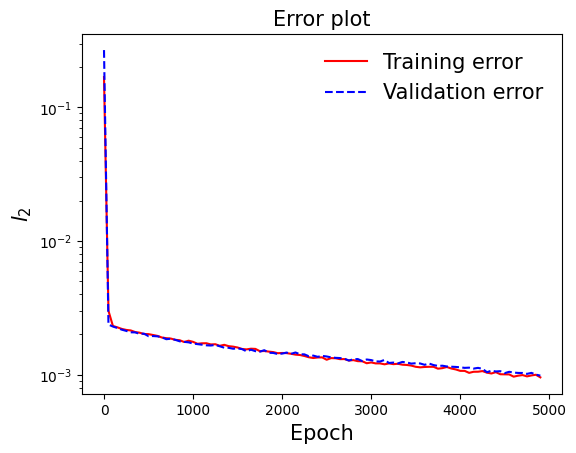

In [100]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.semilogy(Step, T_error,'r',label='Training error')
plt.semilogy(Step, V_error,'b--',label='Validation error')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel(r'$l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [101]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred= net9(ran_input, target)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x14ad11a01430>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

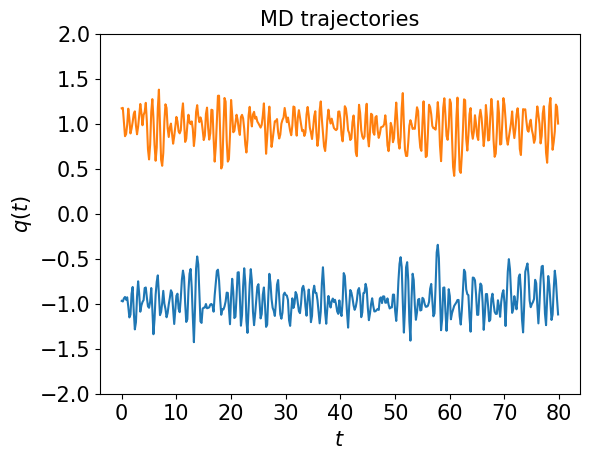

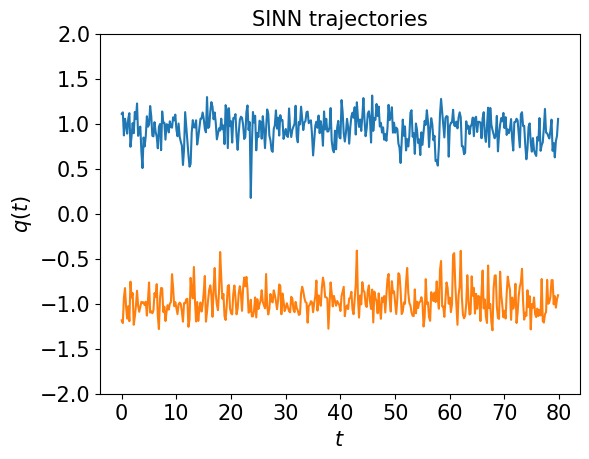

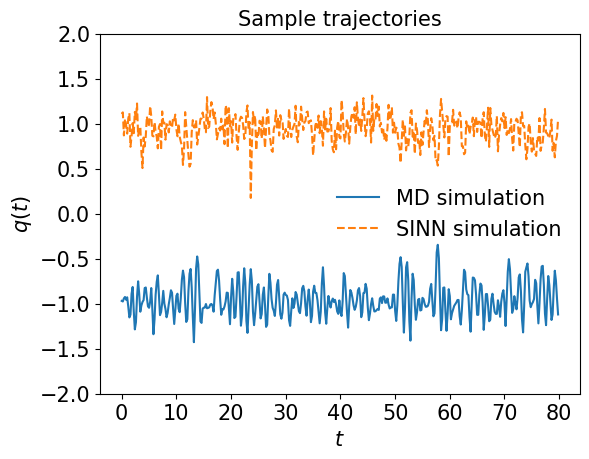

In [102]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
# plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
# plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 0], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 0],'--',label='SINN simulation')
# plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

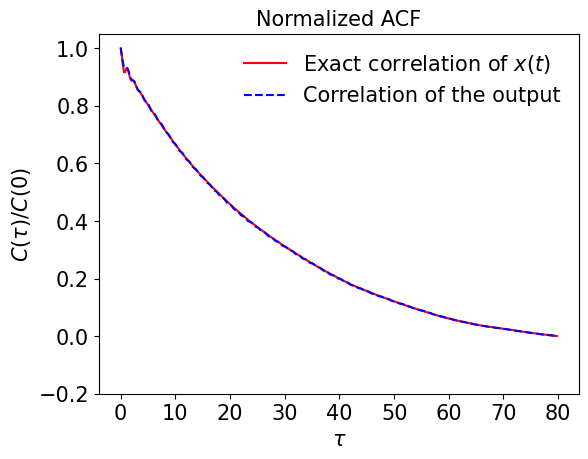

In [103]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $x(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
# plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

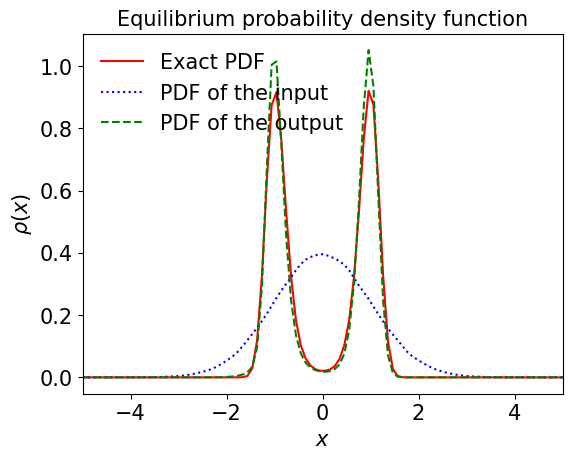

In [104]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
# plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

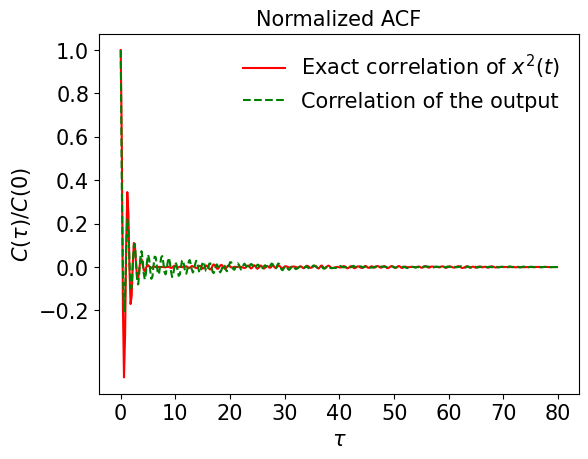

In [105]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $x^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
# plt.xlim(0,30)
plt.xlabel(r'$\tau$',fontsize=15)
plt.ylabel(r'$C(\tau)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)

# END